### Portfolio Analysis  (Including Cryptocurrency, Metals & Stocks)

Portfolio Analysis is the process of reviewing or assessing the elements of the entire portfolio of securities or products in a business. The analysis also helps in proper resource/asset allocation to different elements in the portfolio.

##### This notebook:

Runs an example Monte Carlo Simulation for an optimal portfolio with resulting returns
Creates an Efficient Frontier which is used to identify a set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return

In [26]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime
import scipy.optimize as sco
from scipy import stats
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import hvplot.pandas 
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [27]:
tickers = ['BTC-USD', 'ETH', 'BCH','GC=F', 'SI=F', '^GSPC']

data = yf.download(tickers, '2019-04-01')['Adj Close']

data.columns = ['Bitcoin Cash','Bitcoin', 'Etherum', 'Gold', 'Silver', 'S&P500' ]
data.fillna(method='ffill', inplace=True)

data.tail()

[*********************100%***********************]  6 of 6 completed


,Bitcoin Cash,Bitcoin,Etherum,Gold,Silver,S&P500
Date,,,,,,
2020-05-01,17.32,8864.766602,11.60,1710.199951,15.065,2830.709961
2020-05-02,17.32,8988.596680,11.60,1710.199951,15.065,2830.709961
2020-05-03,17.32,8897.468750,11.60,1706.400024,14.965,2830.709961
2020-05-04,17.41,8897.468750,11.56,1711.699951,14.875,2842.739990
2020-05-05,17.41,8892.757812,11.56,1711.699951,14.875,2842.739990


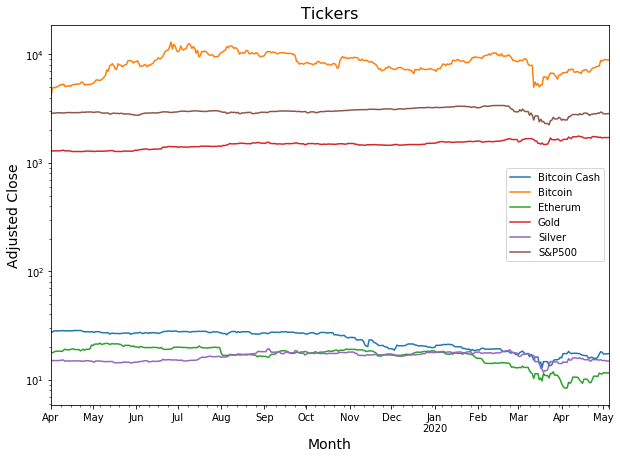

In [68]:
# Visualization
#figure(num=None, figsize=(20,20), dpi=100, facecolor='w', edgecolor='k')
data.plot(logy=True, figsize=(10,7))
# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Tickers", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Adjusted Close', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.show()

#### Performance 

Calculate Daily Returns & Cumulative Returns

In [29]:
# Use the `pct_change` function to calculate daily returns for each stock
daily_returns = data.pct_change()
daily_returns.tail()

,Bitcoin Cash,Bitcoin,Etherum,Gold,Silver,S&P500
Date,,,,,,
2020-05-01,-0.035098,0.023816,0.025641,0.008729,0.000000,-0.028059
2020-05-02,0.000000,0.013969,0.000000,0.000000,0.000000,0.000000
2020-05-03,0.000000,-0.010138,0.000000,-0.002222,-0.006638,0.000000
2020-05-04,0.005196,0.000000,-0.003448,0.003106,-0.006014,0.004250
2020-05-05,0.000000,-0.000529,0.000000,0.000000,0.000000,0.000000


In [30]:
#Describe daily returns
daily_returns.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Bitcoin Cash,400.0,-0.000955,0.022079,-0.136098,-0.006705,0.000000,0.003110,0.150467
Bitcoin,400.0,0.002874,0.043091,-0.371695,-0.015654,0.000951,0.020648,0.181878
Etherum,400.0,-0.000797,0.025074,-0.119416,-0.007634,0.000000,0.004899,0.177533
Gold,400.0,0.000762,0.010205,-0.047732,-0.001422,0.000000,0.003206,0.076411
Silver,400.0,0.000116,0.016962,-0.122183,-0.003321,0.000000,0.004651,0.110799
S&P500,400.0,0.000111,0.016233,-0.119841,-0.001588,0.000000,0.003364,0.093828


In [31]:
columns=['Bitcoin Cash', 'Bitcoin', 'Etherum', 'Gold', 'Silver', 'S&P500']
daily_returns.hvplot.box(y=columns, group_label='Ticker', legend=False, value_label='Daily Returns', invert=True)

:BoxWhisker   [Ticker]   (Daily Returns)

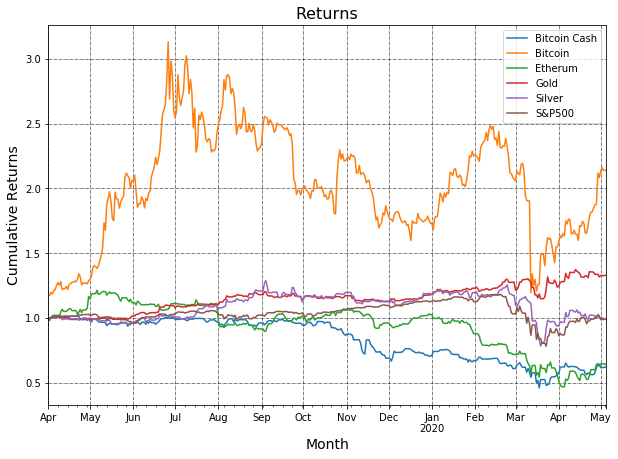

In [32]:
# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Returns", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xlabel('Month', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [33]:
# Calculate the standard deviation for each portfolio. Which portfolios are riskier than the S&P 500?
portfolio_std = daily_returns.std()
portfolio_std

Bitcoin Cash    0.022079
Bitcoin         0.043091
Etherum         0.025074
Gold            0.010205
Silver          0.016962
S&P500          0.016233
dtype: float64

In [34]:
# Determine which portfolios are riskier than the S&P 500
portfolio_std[(portfolio_std['S&P500'] < portfolio_std)]

Bitcoin Cash    0.022079
Bitcoin         0.043091
Etherum         0.025074
Silver          0.016962
dtype: float64

#### Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

* Calculate the correlation between each stock to determine which portfolios may mimick the S&P 500
* Calculate and plot a 60 day Beta

In [35]:
# Use the `corr` function to calculate correlations for each stock pair
correlation = daily_returns.corr()
correlation

,Bitcoin Cash,Bitcoin,Etherum,Gold,Silver,S&P500
Bitcoin Cash,1.000000,0.178331,0.404421,-0.127974,-0.121401,0.553645
Bitcoin,0.178331,1.000000,0.209348,0.064687,0.004895,0.266805
Etherum,0.404421,0.209348,1.000000,0.014428,-0.062221,0.573487
Gold,-0.127974,0.064687,0.014428,1.000000,0.735191,-0.001715
Silver,-0.121401,0.004895,-0.062221,0.735191,1.000000,-0.064470
S&P500,0.553645,0.266805,0.573487,-0.001715,-0.064470,1.000000


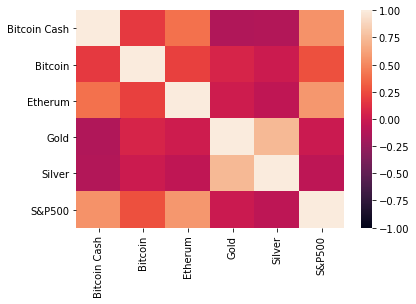

In [22]:
# Create a heatmap from the correlation values and adjust the scale
sns.heatmap(correlation, vmin=-1, vmax=1)

Evaluate Riskiness

In [37]:
# Use the `std` function and multiply by the square root of the number of trading days in a year to get annualized volatility
volatility = daily_returns.std() * np.sqrt(252)
volatility.sort_values(inplace=True)
volatility

Gold            0.162399
S&P500          0.258314
Silver          0.269902
Bitcoin Cash    0.351346
Etherum         0.399034
Bitcoin         0.685695
dtype: float64

In [62]:
# Calculate Beta for the portfolio compared to the total market (S&P 500)
for item in data:
    covariance = daily_returns[item].cov(daily_returns['S&P500'])
    variance = daily_returns['S&P500'].var()
    beta = round(covariance / variance, 2)
    print(item, ":", beta)
   

Bitcoin Cash : 0.75
Bitcoin : 0.71
Etherum : 0.89
Gold : -0.0
Silver : -0.07
S&P500 : 1.0


### Sharpe Ratios
In reality, investment managers and thier institutional investors look at the ratio of return-to-risk, and not just returns alone. (After all, if you could invest in one of two portfolios, each offered the same 10% return, yet one offered lower risk, you'd take that one, right?)

Calculate and plot the annualized Sharpe ratios for all portfolios to determine which portfolio has the best performance

In [63]:
# Annualzied Sharpe Ratios
sharpe_ratios = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))
sharpe_ratios

Bitcoin Cash   -0.686651
Bitcoin         1.058811
Etherum        -0.504336
Gold            1.185320
Silver          0.108354
S&P500          0.108736
dtype: float64

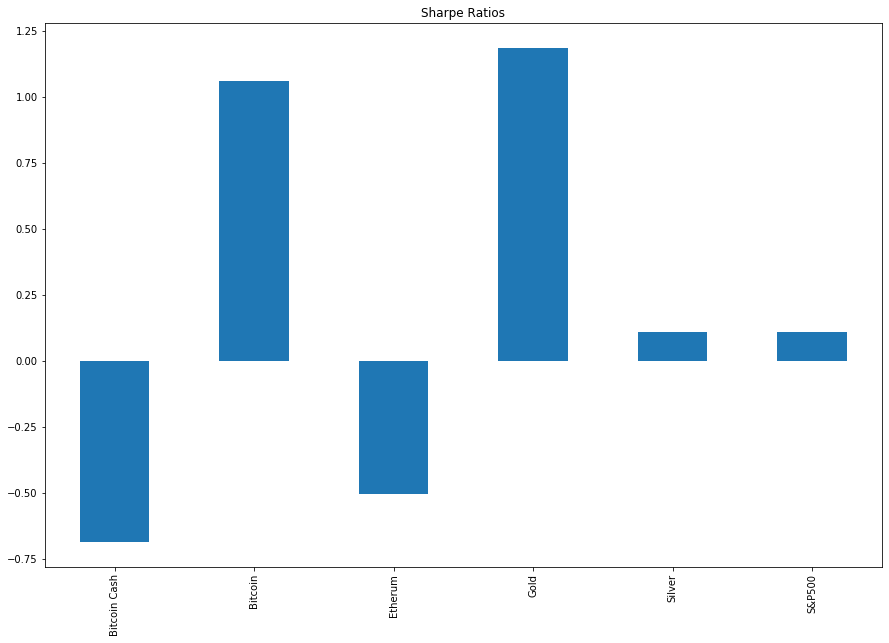

In [64]:
sharpe_ratios.plot(figsize=[15,10], kind="bar", title="Sharpe Ratios")

In [70]:
cov_matrix_annual = daily_returns.cov() * 252
cov_matrix_annual

,Bitcoin Cash,Bitcoin,Etherum,Gold,Silver,S&P500
Bitcoin Cash,0.122849,0.042756,0.056422,-0.007267,-0.011458,0.050005
Bitcoin,0.042756,0.467919,0.057001,0.007169,0.000902,0.047030
Etherum,0.056422,0.057001,0.158435,0.000930,-0.006669,0.058822
Gold,-0.007267,0.007169,0.000930,0.026245,0.032071,-0.000072
Silver,-0.011458,0.000902,-0.006669,0.032071,0.072506,-0.004473
S&P500,0.050005,0.047030,0.058822,-0.000072,-0.004473,0.066402


In [75]:
#Expected portfolio variance= WT * (Covariance Matrix) * W
weights = np.array([0.1, 0.2, 0.1, 0.2, 0.1, 0.3])
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.04757193647382962

In [76]:
# Expected Portfolio volatility
port_volatility = np.sqrt(port_variance)
port_volatility

0.21810991832979448

In [78]:
# Expected Annual Return
portfolioSimpleAnnualReturn = np.sum(daily_returns.mean()*weights) * 252
portfolioSimpleAnnualReturn

0.15044212352368383

In [79]:
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100)+'%'

print("Expected annual return : "+ percent_ret)
print('Annual volatility/standard deviation/risk : '+percent_vols)
print('Annual variance : '+percent_var)

Expected annual return : 15.0%
Annual volatility/standard deviation/risk : 22.0%
Annual variance : 5.0%


### Portfolio Optimization: Monte Carlo Simulation

Portfolio Optimization is used for risk-averse investors to construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward

Single Random Simulation

* Set our weights to a random numpy array
* Rebalance the weights so they add up to one
* Calculate the expected portfolio return
* Calculate the expected portfolio volatility
* Calculate the Sharpe Ratio

In [84]:
print(data.columns)

weights = np.array(np.random.random(6))
print('Random Weights:')
print(weights)

print('Rebalance')
weights = weights/np.sum(weights)
print(weights)

# expected return
print('Expected Portfolio Return')
exp_ret = np.sum((daily_returns.mean()*weights)*252)
print(exp_ret)

# expected volatility
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T,np.dot(daily_returns.cov()*252, weights)))
print(exp_vol)

# Sharpe Ratio
print('Sharpe Ratio')
SR = exp_ret/exp_vol
print(SR)

Index(['Bitcoin Cash', 'Bitcoin', 'Etherum', 'Gold', 'Silver', 'S&P500'], dtype='object')
Random Weights:
[0.08491836 0.79495282 0.08513092 0.71144419 0.45092992 0.77470652]
Rebalance
[0.02926118 0.27392493 0.02933442 0.24514952 0.15538148 0.26694846]
Expected Portfolio Return
0.24455422213771164
Expected Volatility
0.2377744099894817
Sharpe Ratio
1.028513632516341


Multiple Random Simulation

In [105]:
num_ports = 5000
all_weights = np.zeros((num_ports, len(data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports): 
    # weights 
    weights = np.array(np.random.random(6)) 
    weights = weights/np.sum(weights)  
    	
    # save the weights
    all_weights[ind,:] = weights
	    
    # expected return 
    ret_arr[ind] = np.sum((daily_returns.mean()*weights)*252)

    # expected volatility 
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(daily_returns.cov()*252, weights)))

    # Sharpe Ratio 
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [106]:
# Maximum Sharpe Ratio
sharpe_arr.max()

1.190356544304429

In [138]:
# Get the location of the maximum Sharpe Ratio & allocation for that index
sharpe_arr.argmax()


1765

In [139]:
all_weights[1765,:]

array([0.02694781, 0.2599026 , 0.01528558, 0.40577814, 0.19691049,
       0.09517538])

Text(0, 0.5, 'Return')

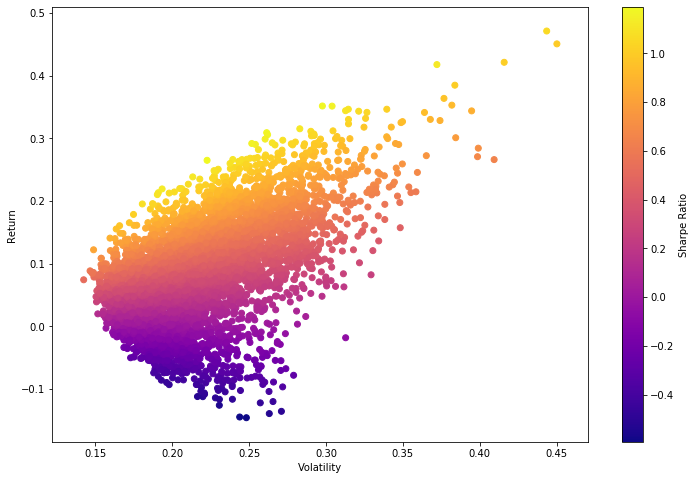

In [113]:
# Plot the data
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

Highlight the location of the maximum Sharpe Ratio.

In [114]:
max_sr_ret = ret_arr[1765]
max_sr_vol = vol_arr[1765]

In [180]:
import holoviews as hv
scatter = hv.Scatter((vol_arr, ret_arr, sharpe_arr), 'Volatility', ['Return', 'Sharpe Ratio'])
max_sharpe = hv.Scatter([(max_sr_vol,max_sr_ret)])

scatter.opts(color='Sharpe Ratio', cmap='plasma', width=600, height=400, colorbar=True, padding=0.1) *\
max_sharpe.opts(color='red', line_color='black', size=10)

:Overlay
   .Scatter.I  :Scatter   [Volatility]   (Return,Sharpe Ratio)
   .Scatter.II :Scatter   [x]   (y)

### Portfolio Optimization: Optimization Algorithm Using Scipy

In [153]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum((daily_returns.mean()*weights)*252)
    vol = np.sqrt(np.dot(weights.T,np.dot(daily_returns.cov()*252, weights)))
    sr = ret/vol 
    return np.array([ret,vol,sr])

In [170]:
# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
	return get_ret_vol_sr(weights)[2] * -1

In [171]:
# check allocation sums to 1
def check_sum(weights): 
	return np.sum(weights) - 1

In [172]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [173]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1),(0,1), (0,1))

In [174]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,weights,method='SLSQP',bounds=bounds,constraints=cons)
opt_results.x

array([0.00000000e+00, 1.72391425e-01, 0.00000000e+00, 8.27608575e-01,
       4.51523072e-16, 0.00000000e+00])

In [159]:
get_ret_vol_sr(opt_results.x)

array([0.283781  , 0.18419464, 1.54065825])

In [175]:
# Our returns go from -0.2 to somewhere along 0.5
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(-0.2,0.5,100) 
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [177]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,weights,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

In [181]:
scatter*hv.Curve((frontier_volatility, frontier_y)).opts(color='green', line_dash='dashed')


:Overlay
   .Scatter.I :Scatter   [Volatility]   (Return,Sharpe Ratio)
   .Curve.I   :Curve   [x]   (y)